Testing Symmetric Distance Matrix...


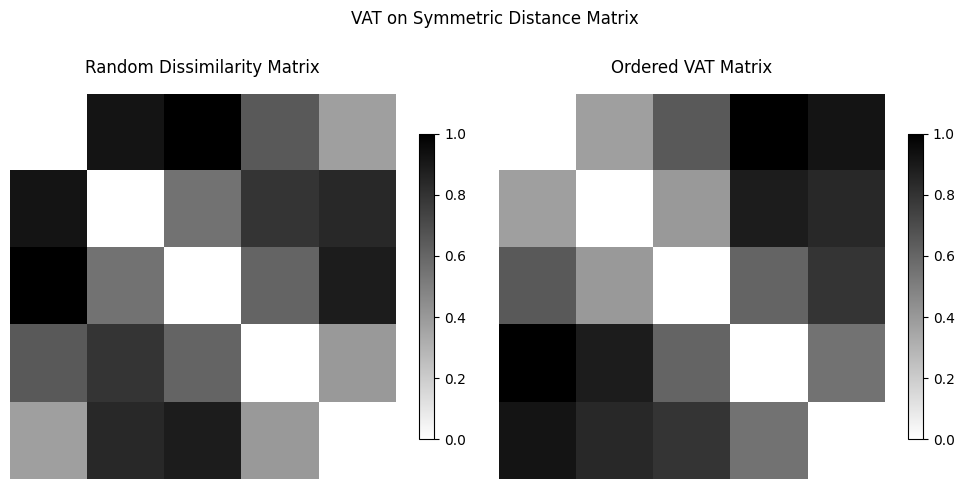

Testing Circular Data...


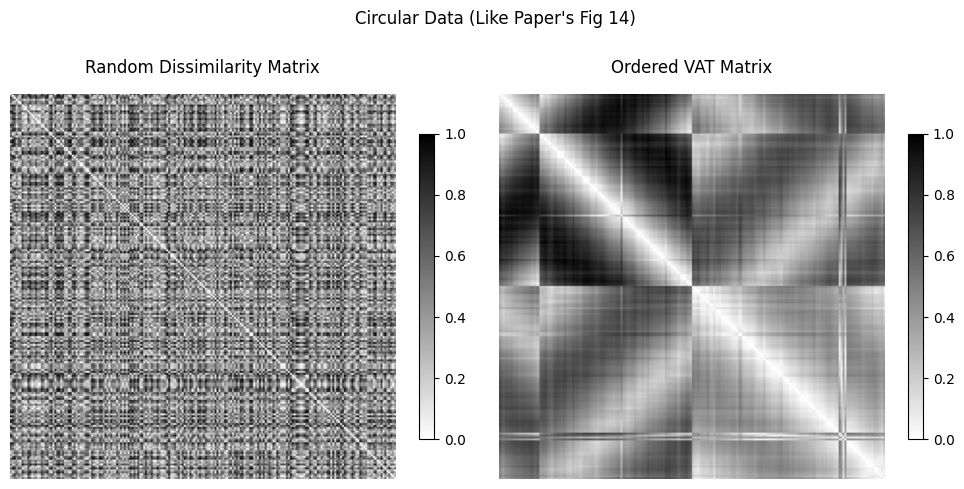


Testing IRIS Dataset...


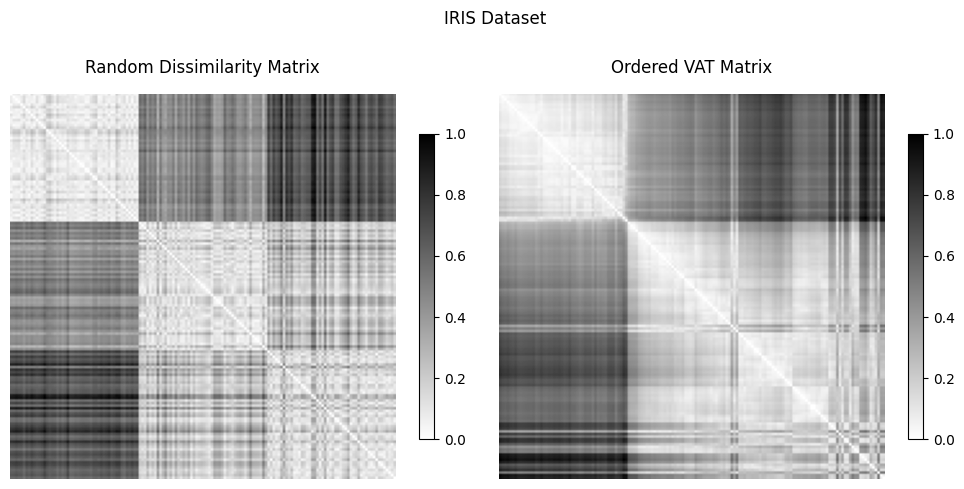


Testing Mixed Data...


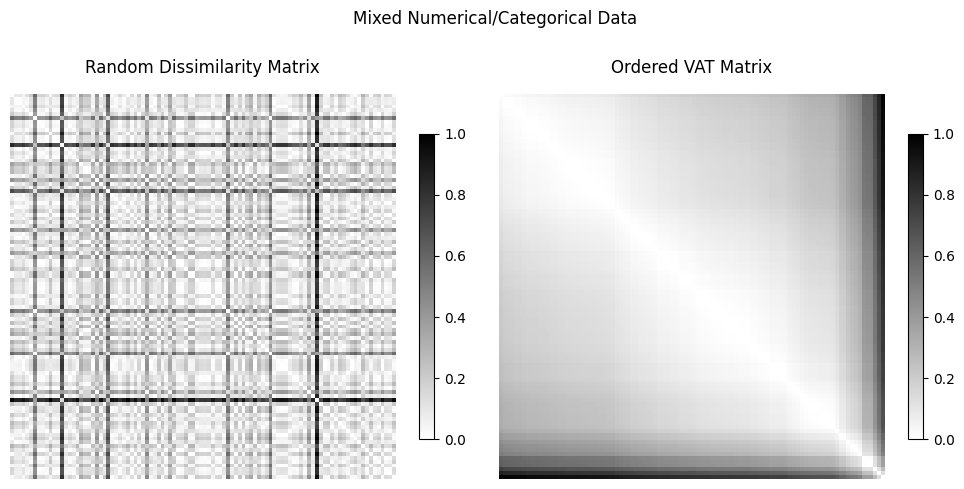


Testing Large Dataset...


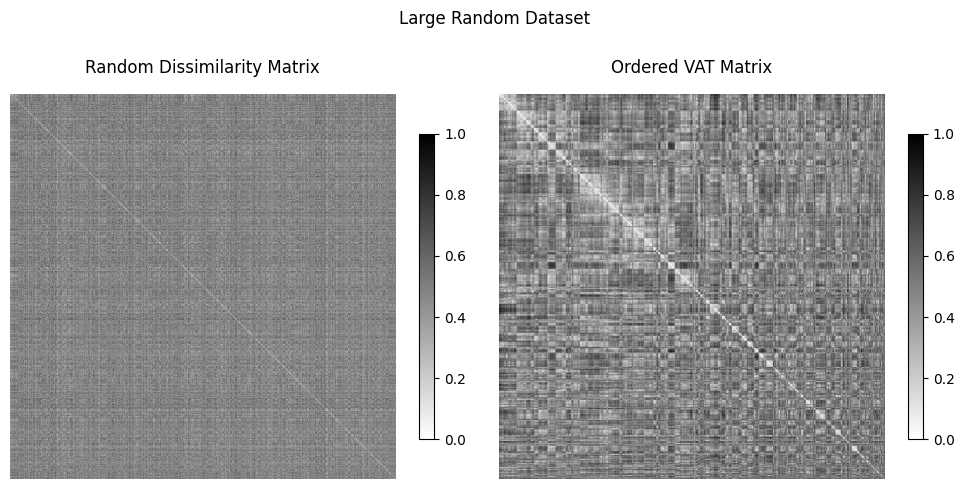


Testing Employee Dataset...

All tests completed successfully!

Testing Linear Data...


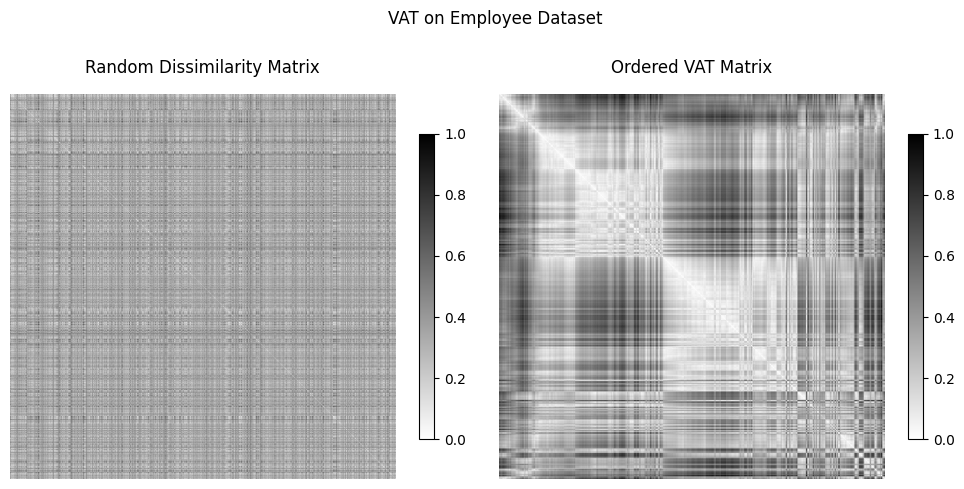

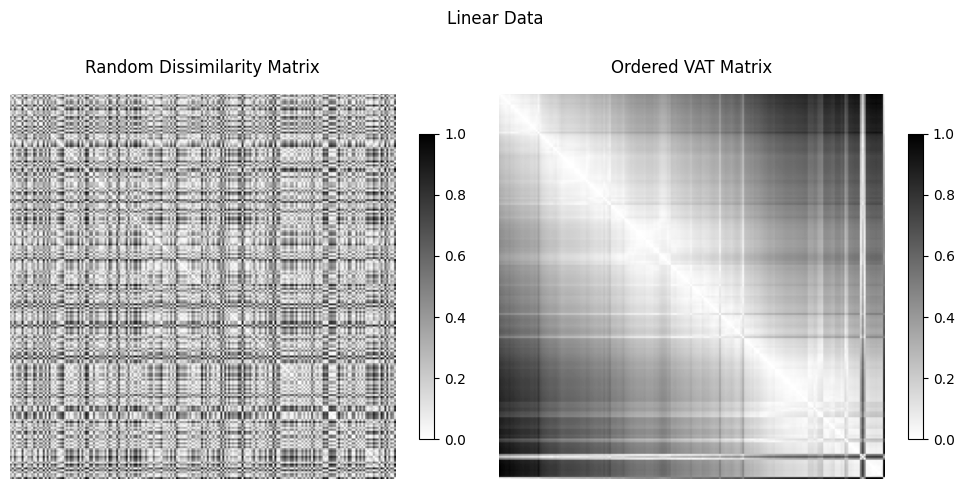

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import shortest_path
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.datasets import make_circles, load_iris
from matplotlib.colors import LinearSegmentedColormap
import warnings
 
class VAT:
    """Visual Assessment of Tendency (VAT) implementation matching paper format"""
   
    def __init__(self, normalize=True, colormap='gray_r', n_samples_max=5000):
        self.normalize = normalize
        self.n_samples_max = n_samples_max
        self.cmap = plt.cm.gray_r if colormap == 'gray_r' else LinearSegmentedColormap.from_list('vat_cmap', ['black', 'white'], N=256)
   
    def fit(self, data):
        if isinstance(data, pd.DataFrame):
            data = self._preprocess_data(data)
       
        if len(data) > self.n_samples_max:
            data = data[np.random.choice(len(data), self.n_samples_max, replace=False)]
       
        # Store original data for visualization
        self.original_data = data.copy()
       
        # Compute dissimilarity matrix
        if data.shape[1] > 2 and self._is_nonlinear(data):
            self.R_ = self._geodesic_distance(data)
        else:
            self.R_ = squareform(pdist(data, 'euclidean'))
       
        if self.normalize:
            self.R_ = (self.R_ - self.R_.min()) / (self.R_.max() - self.R_.min())
       
        # VAT ordering
        self.order_ = self._vat_ordering(self.R_)
        self.R_ordered_ = self.R_[np.ix_(self.order_, self.order_)]
        return self
   
    def _preprocess_data(self, data):
        num_cols = data.select_dtypes(include=[np.number]).columns
        cat_cols = data.select_dtypes(exclude=[np.number]).columns
       
        # Impute missing values
        data[num_cols] = SimpleImputer(strategy='mean').fit_transform(data[num_cols])
        data[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(data[cat_cols])
       
        # Encode categorical variables
        if len(cat_cols) > 0:
            encoder = OneHotEncoder(drop='first', sparse_output=False)
            encoded = encoder.fit_transform(data[cat_cols])
            return np.hstack((data[num_cols].values, encoded))
        return data[num_cols].values
   
    def _is_nonlinear(self, X):
        pca = PCA(n_components=2).fit(X)
        return pca.explained_variance_ratio_[0] < 0.6
   
    def _geodesic_distance(self, X):
        n_neighbors = min(15, X.shape[0]-1)
        nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X)
        distances, indices = nbrs.kneighbors(X)
       
        dist_matrix = np.zeros((X.shape[0], X.shape[0]))
        for i in range(X.shape[0]):
            for j, d in zip(indices[i], distances[i]):
                if i != j:
                    dist_matrix[i,j] = d
                    dist_matrix[j,i] = d
       
        dist_matrix[dist_matrix == 0] = np.inf
        np.fill_diagonal(dist_matrix, 0)
        return shortest_path(dist_matrix, directed=False)
   
    def _vat_ordering(self, R):
        n = R.shape[0]
        P = np.zeros(n, dtype=int)
        J = set(range(n))
       
        max_idx = np.unravel_index(np.argmax(R), R.shape)
        P[0] = max_idx[0]
        I = {P[0]}
        J.remove(P[0])
       
        for r in range(1, n):
            submatrix = R[np.array(list(I))[:, None], np.array(list(J))]
            min_val = np.min(submatrix)
            min_mask = submatrix == min_val
           
            candidates = np.argwhere(min_mask)
            if len(candidates) == 0:
                j_in_J = list(J)[0]
                P[r] = j_in_J
                I.add(j_in_J)
                J.remove(j_in_J)
                continue
               
            selected = candidates[np.argmax(candidates[:, 0])]
            i_in_I = list(I)[selected[0]]
            j_in_J = list(J)[selected[1]]
           
            P[r] = j_in_J
            I.add(j_in_J)
            J.remove(j_in_J)
       
        return P
   
    def plot_paper_style(self, title=None, figsize=(10, 5)):
        """Create visualization matching paper format: random and ordered matrices side by side"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
       
        # Random dissimilarity matrix
        img1 = ax1.imshow(self.R_, cmap=self.cmap, aspect='equal',
                         vmin=0, vmax=1 if self.normalize else None)
        ax1.set_title('Random Dissimilarity Matrix', pad=15)
        ax1.axis('off')
        plt.colorbar(img1, ax=ax1, shrink=0.7)
       
        # Ordered VAT matrix
        img2 = ax2.imshow(self.R_ordered_, cmap=self.cmap, aspect='equal',
                         vmin=0, vmax=1 if self.normalize else None)
        ax2.set_title('Ordered VAT Matrix', pad=15)
        ax2.axis('off')
        plt.colorbar(img2, ax=ax2, shrink=0.7)
       
        if title:
            fig.suptitle(title, y=1.02)
       
        plt.tight_layout()
        return fig
 
def test_vat():
    """Run all test cases with paper-style visualizations"""
    plt.style.use('default')  # Use default style for paper-like appearance
 
    # Test 0: Symmetric Distance Matrix (Fig 13)
    print("Testing Symmetric Distance Matrix...")
    R = np.array([
    [0.00, 0.71, 0.78, 0.45, 0.23],
    [0.71, 0.00, 0.42, 0.61, 0.55],
    [0.78, 0.42, 0.00, 0.32, 0.65],
    [0.45, 0.61, 0.32, 0.00, 0.20],
    [0.23, 0.55, 0.65, 0.20, 0.00]
])
    vat = VAT()
    vat.fit(R)
    fig = vat.plot_paper_style("VAT on Symmetric Distance Matrix")
    # plt.savefig('vat_paper_symmetric.png', bbox_inches='tight', dpi=300)
    plt.show()
   
    # Test 1: Circular Data (Fig 14)
    print("Testing Circular Data...")
    X_circle, _ = make_circles(n_samples=200, noise=0.05, factor=0.5, random_state=42)
    vat = VAT()
    vat.fit(X_circle)
    fig = vat.plot_paper_style("Circular Data (Like Paper's Fig 14)")
    # plt.savefig('vat_paper_circular.png', bbox_inches='tight', dpi=300)
    plt.show()
   
    # Test 2: IRIS Dataset
    print("\nTesting IRIS Dataset...")
    iris = load_iris()
    X_iris = iris.data
    vat = VAT()
    vat.fit(X_iris)
    fig = vat.plot_paper_style("IRIS Dataset")
    # plt.savefig('vat_paper_iris.png', bbox_inches='tight', dpi=300)
    plt.show()
   
    # Test 3: Mixed Data
    print("\nTesting Mixed Data...")
    rng = np.random.RandomState(42)
    mixed_data = pd.DataFrame({
        'age': rng.normal(40, 15, 100),
        'income': rng.lognormal(10, 0.5, 100),
        'gender': rng.choice(['M', 'F'], 100),
        'education': rng.choice(['HS', 'College', 'Grad'], 100)
    })
    vat = VAT()
    processed_data = vat._preprocess_data(mixed_data)
    vat.fit(processed_data)
    fig = vat.plot_paper_style("Mixed Numerical/Categorical Data")
    # plt.savefig('vat_paper_mixed.png', bbox_inches='tight', dpi=300)
    plt.show()
 
 
    # Test 4: Large Dataset
    print("\nTesting Large Dataset...")
    X_large = np.random.rand(1000, 5)
    vat = VAT(n_samples_max=5000)  # Adjust based on your RAM capacity
    vat.fit(X_large)
    fig = vat.plot_paper_style("Large Random Dataset")
    # plt.savefig('vat_paper_large.png', bbox_inches='tight', dpi=300)
    plt.show()
   
 
   
    # Test 5: Diabetes Dataset
    print("\nTesting Employee Dataset...")
    # Load your dataset (adjust path as needed)
    df = pd.read_csv('employee.csv') # Example dataset
    # Initialize VAT with subsampling
    vat = VAT(n_samples_max=5000)  # Adjust based on your RAM capacity
    # Fit and plot
    vat.fit(df)
    vat.plot_paper_style("VAT on Employee Dataset")
 
 
    print("\nAll tests completed successfully!")
 
 
    # Test 2: Linear Data (New test case)
    print("\nTesting Linear Data...")
    X_linear = np.random.rand(200, 2)
    X_linear[:, 1] = 2 * X_linear[:, 0] + 0.1 * np.random.randn(200)  # y = 2x + noise
    vat = VAT()
    vat.fit(X_linear)
    vat.plot_paper_style("Linear Data")
 
   
   
if __name__ == "__main__":
   
    test_vat()